# Эксперименты по классификации упаковок напитков

## Цель проекта
Разработать модель классификации изображений упаковок напитков на 3 класса:
- 🥫 Жестяная банка
- ☕ Картонный стакан  
- 🍼 Пластиковая бутылка

## Задачи
1. Исследовать собранный датасет
2. Сравнить 2 архитектуры из разных семейств (ResNet vs ConvNeXt)
3. Подобрать гиперпараметры
4. Оценить результаты и выбрать лучшую модель

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from collections import Counter

from fine_tuning.config import RAW_DATA_DIR, CLASS_FOLDERS, CLASS_NAMES
from fine_tuning.dataset import create_splits, BeverageDataset, train_transform, val_transform
from fine_tuning.config import TRAIN_CSV, VAL_CSV, PROCESSED_DATA_DIR

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

2025-11-02 22:39:26.233 | INFO     | fine_tuning.config:<module>:10 - PROJ_ROOT path is: /home/jaennil/dev/mlm/fine_tuning


## 1. Исследование датасета

Сначала изучим структуру и содержание нашего датасета.

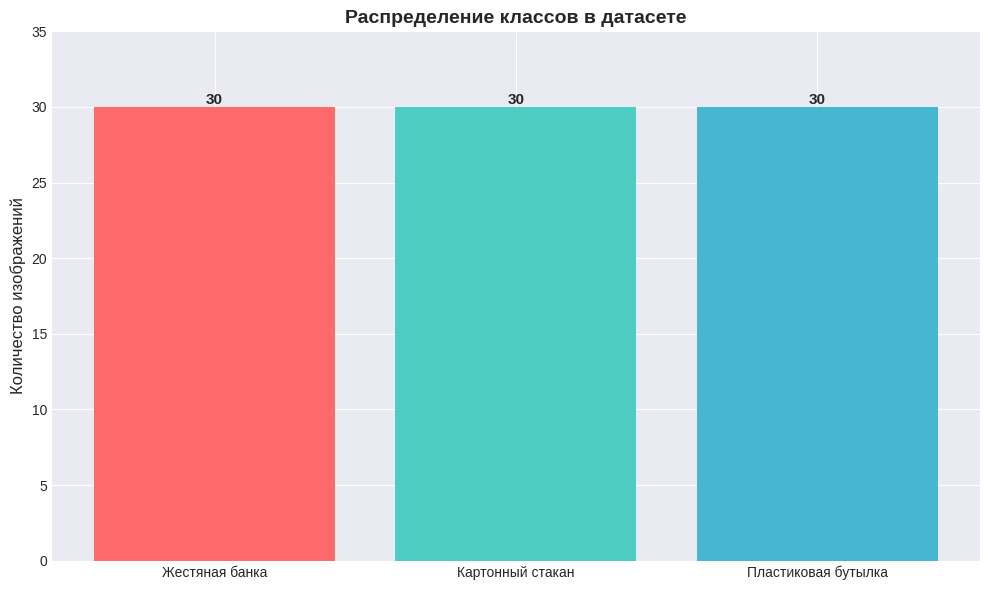


Общее количество изображений: 90
Датасет сбалансирован: True


In [2]:
# Подсчитаем количество изображений в каждом классе
data_stats = {}
for folder in CLASS_FOLDERS:
    folder_path = RAW_DATA_DIR / folder
    if folder_path.exists():
        images = list(folder_path.glob("*.*"))
        images = [img for img in images if img.suffix.lower() in {".png", ".jpg", ".jpeg", ".webp"}]
        data_stats[folder] = len(images)
    else:
        data_stats[folder] = 0

# Визуализация
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(CLASS_NAMES, data_stats.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax.set_ylabel('Количество изображений', fontsize=12)
ax.set_title('Распределение классов в датасете', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(data_stats.values()) + 5)

# Добавим значения на столбцы
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nОбщее количество изображений: {sum(data_stats.values())}")
print(f"Датасет сбалансирован: {len(set(data_stats.values())) == 1}")

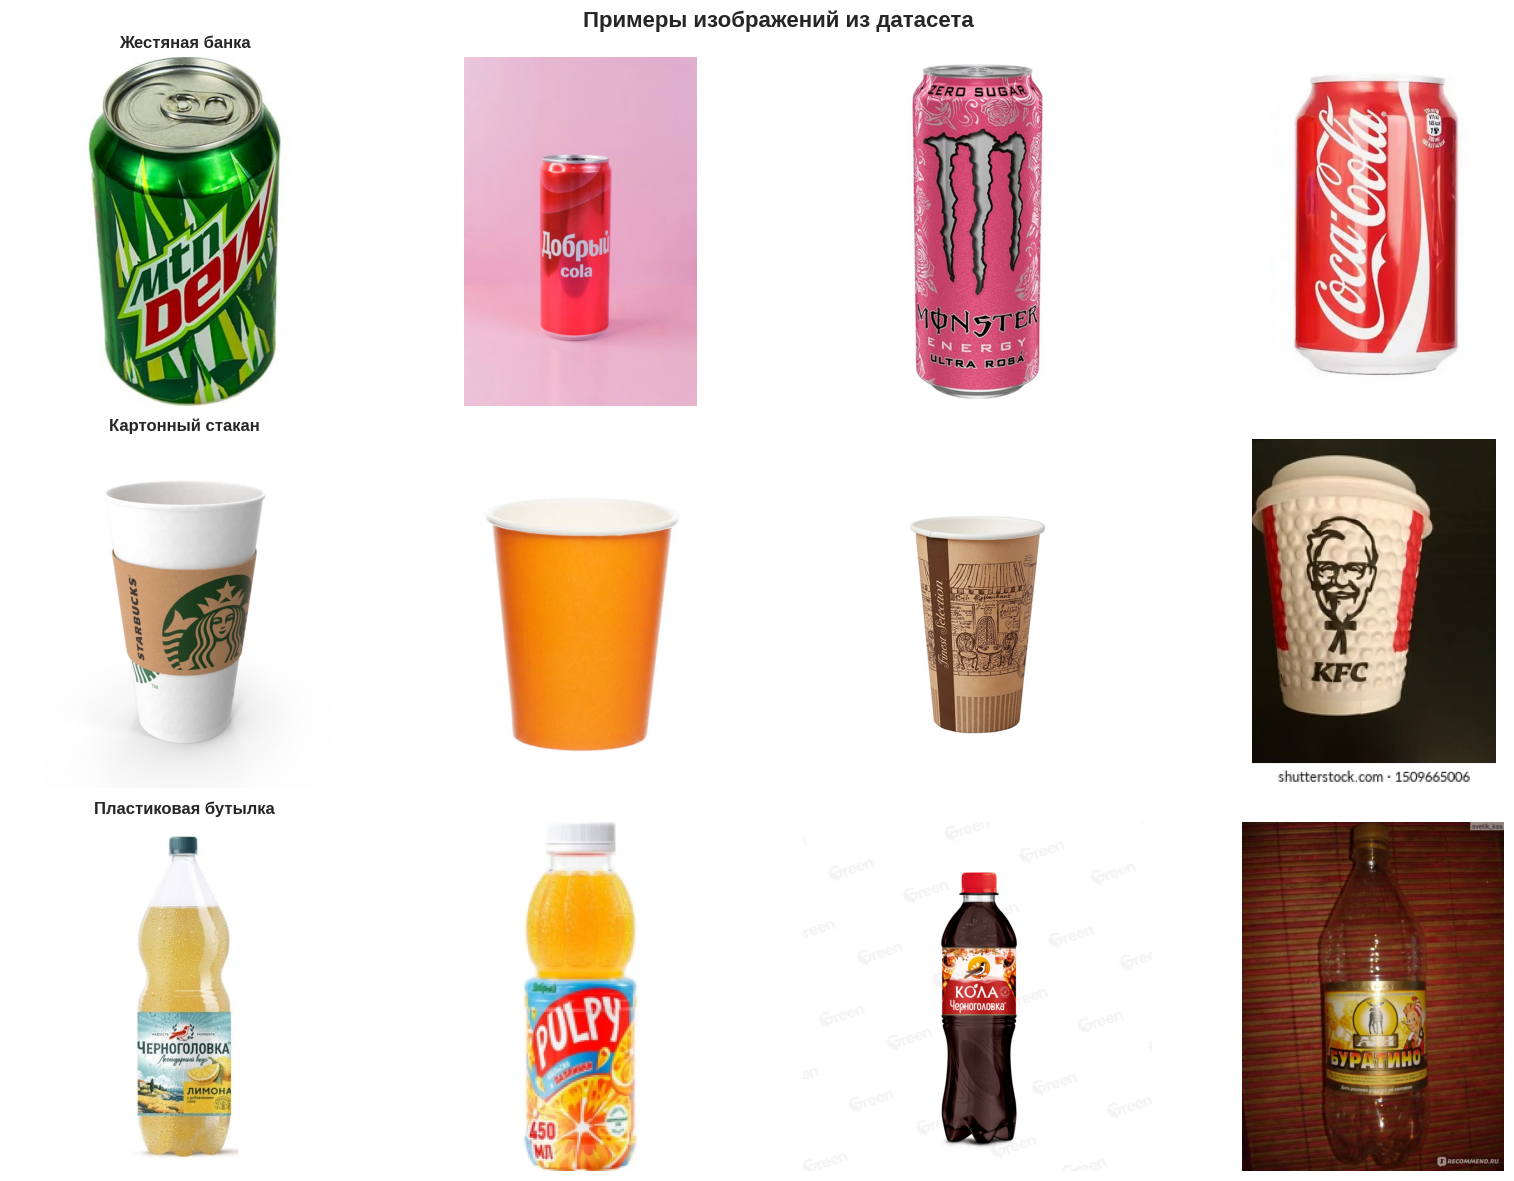

In [3]:
# Визуализация примеров из каждого класса
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Примеры изображений из датасета', fontsize=16, fontweight='bold')

for idx, (folder, class_name) in enumerate(zip(CLASS_FOLDERS, CLASS_NAMES)):
    folder_path = RAW_DATA_DIR / folder
    images = list(folder_path.glob("*.*"))[:4]  # Берем первые 4 изображения
    
    for i, img_path in enumerate(images):
        img = Image.open(img_path).convert('RGB')
        axes[idx, i].imshow(img)
        axes[idx, i].axis('off')
        if i == 0:
            axes[idx, i].set_title(f'{class_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 2. Разделение на train/val

Создадим разделение 80/20 с стратификацией по классам для сохранения пропорций.

In [4]:
# Создаем разделение
create_splits()

# Загружаем CSV
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)

print(f"Тренировочная выборка: {len(train_df)} изображений")
print(f"Валидационная выборка: {len(val_df)} изображений")
print(f"\nРаспределение по классам:")
print("\nTrain:")
print(train_df['label'].value_counts().sort_index())
print("\nValidation:")
print(val_df['label'].value_counts().sort_index())

2025-11-02 22:39:28.201 | INFO     | fine_tuning.dataset:create_splits:67 - данные разделены на train (72), val (18)
Тренировочная выборка: 72 изображений
Валидационная выборка: 18 изображений

Распределение по классам:

Train:
label
0    24
1    24
2    24
Name: count, dtype: int64

Validation:
label
0    6
1    6
2    6
Name: count, dtype: int64


## 3. Стратегия Transfer Learning

### Почему Transfer Learning?
- Малый датасет (91 изображение)
- Предобученные веса на ImageNet содержат полезные признаки
- Ускоряет обучение и улучшает результаты

### Стратегия двухфазного обучения:

**Фаза 1: Заморозка backbone (epochs 0-5/6)**
- Замораживаем все слои, кроме классификатора
- Обучаем только последний FC слой
- Цель: адаптировать классификатор к нашим классам
- LR: 1e-3 (ResNet) / 5e-4 (ConvNeXt)

**Фаза 2: Fine-tuning (epochs 5/6 - end)**
- Размораживаем все слои
- Дообучаем всю сеть
- Цель: тонкая настройка признаков под нашу задачу
- LR: 1e-4 / 5e-5 (уменьшаем в 10 раз)

### Зачем две фазы?
- Предотвращение катастрофического забывания
- Стабильная конвергенция
- Лучшие результаты на малых датасетах

## 4. Аугментации данных

### Применяемые аугментации (только для train):

1. **Geometric**: HorizontalFlip, RandomRotate90
2. **Color**: RandomBrightnessContrast
3. **Noise**: GaussNoise
4. **Weather**: RandomFog

### Зачем аугментации?
- Увеличивают разнообразие данных
- Предотвращают переобучение
- Модель учится инвариантности к трансформациям

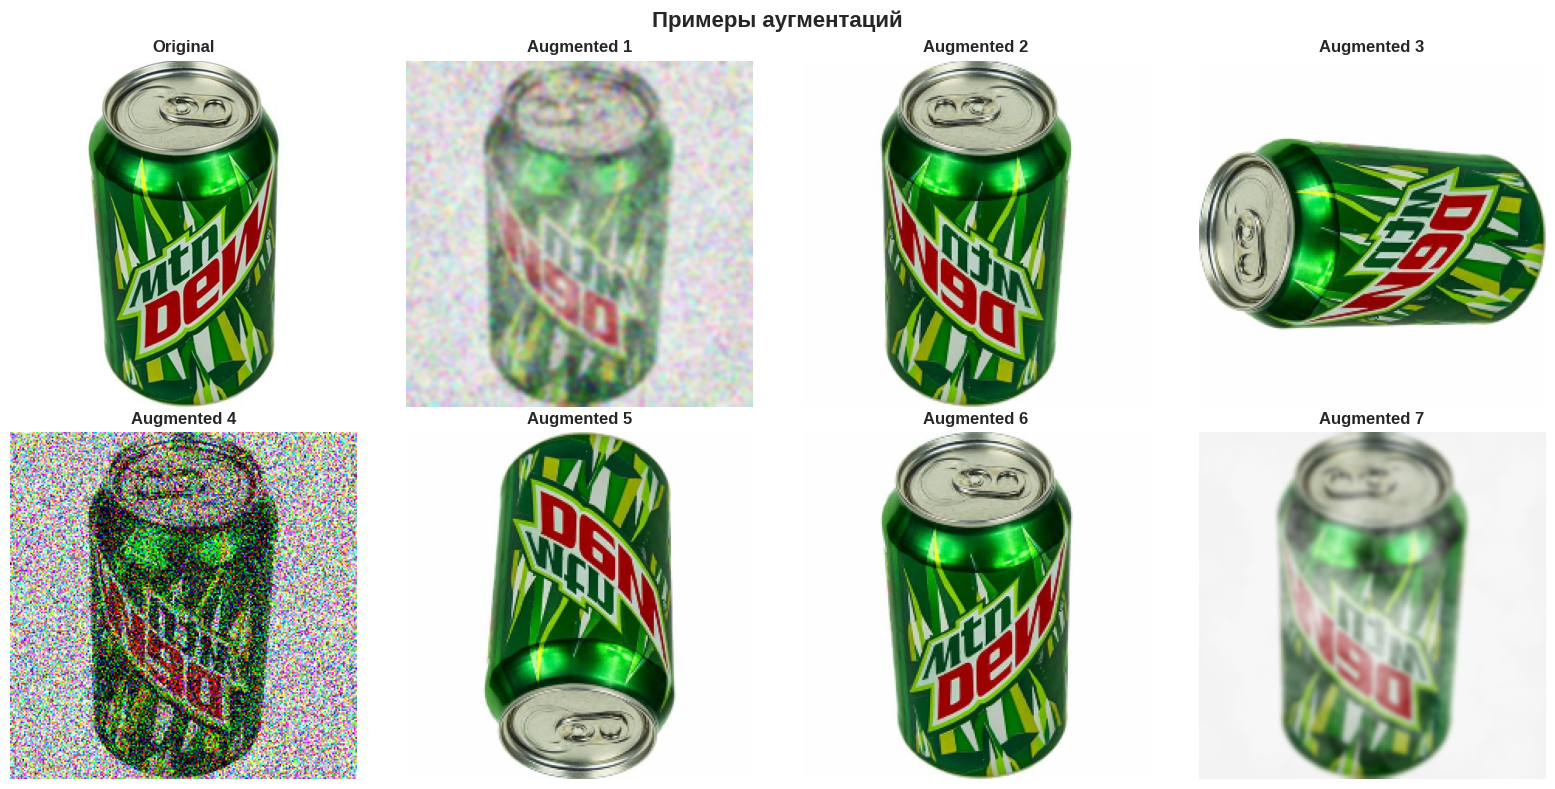

In [5]:
# Визуализация аугментаций
sample_img_path = list((RAW_DATA_DIR / "can").glob("*.png"))[0]
sample_img = np.array(Image.open(sample_img_path).convert('RGB'))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Примеры аугментаций', fontsize=16, fontweight='bold')

# Оригинал
axes[0, 0].imshow(sample_img)
axes[0, 0].set_title('Original', fontweight='bold')
axes[0, 0].axis('off')

# Применяем аугментации несколько раз
for i in range(7):
    augmented = train_transform(image=sample_img)['image']
    # Денормализуем для отображения
    img_show = augmented.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_show = img_show * std + mean
    img_show = np.clip(img_show, 0, 1)
    
    row = (i + 1) // 4
    col = (i + 1) % 4
    axes[row, col].imshow(img_show)
    axes[row, col].set_title(f'Augmented {i+1}', fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## 5. Эксперименты с моделями

### Выбор архитектур

Сравним **2 семейства** моделей:

#### 1. ResNet (Residual Networks)
- **ResNet34**: Классическая архитектура (2015)
- Остаточные соединения (skip connections)
- 21.3M параметров
- Проверенная временем архитектура

#### 2. ConvNeXt (Modern ConvNet)
- **ConvNeXt-Tiny**: Современная архитектура (2022)
- Модернизация CNN с идеями из Transformers
- 28.6M параметров
- State-of-the-art для CNN

### План экспериментов:
1. Обучить ResNet34
2. Обучить ConvNeXt-Tiny
3. Сравнить результаты
4. Выбрать лучшую модель

In [6]:
from fine_tuning.modeling.train import train_model
from fine_tuning.config import ResNet34Config

print("=" * 60)
print("ЭКСПЕРИМЕНТ 1: ResNet34")
print("=" * 60)

resnet_config = ResNet34Config()
print(f"\nКонфигурация:")
print(f"  - Модель: {resnet_config.model_name}")
print(f"  - Batch size: {resnet_config.batch_size}")
print(f"  - Learning rate: {resnet_config.lr}")
print(f"  - Epochs: {resnet_config.epochs}")
print(f"  - Unfreeze epoch: {resnet_config.unfreeze_epoch}")

resnet_results = train_model(resnet_config)

print(f"\n✅ ResNet34 обучена!")
print(f"Best Accuracy: {resnet_results['best_accuracy']:.4f}")

ЭКСПЕРИМЕНТ 1: ResNet34

Конфигурация:
  - Модель: resnet34
  - Batch size: 16
  - Learning rate: 0.001
  - Epochs: 12
  - Unfreeze epoch: 6
2025-11-02 22:39:30.107 | INFO     | fine_tuning.modeling.train:train_model:18 - starting training with config: ResNet34Config(model_name='resnet34', batch_size=16, lr=0.001, epochs=12, freeze_backbone=True, unfreeze_epoch=6, seed=42, optimizer='Adam', scheduler='StepLR')
2025-11-02 22:39:30.109 | INFO     | fine_tuning.config:seed_everything:80 - seed зафиксирован: 42
2025-11-02 22:39:30.109 | INFO     | fine_tuning.modeling.train:train_model:21 - creating train/validation splits...
2025-11-02 22:39:30.113 | INFO     | fine_tuning.dataset:create_splits:67 - данные разделены на train (72), val (18)
2025-11-02 22:39:30.116 | INFO     | fine_tuning.modeling.train:train_model:29 - train dataset size: 72, val dataset size: 18
2025-11-02 22:39:30.116 | INFO     | fine_tuning.modeling.train:train_model:32 - using device: cpu
2025-11-02 22:39:30.771 | IN

In [7]:
from fine_tuning.config import ConvNextConfig

print("=" * 60)
print("ЭКСПЕРИМЕНТ 2: ConvNeXt-Tiny")
print("=" * 60)

convnext_config = ConvNextConfig()
print(f"\nКонфигурация:")
print(f"  - Модель: {convnext_config.model_name}")
print(f"  - Batch size: {convnext_config.batch_size}")
print(f"  - Learning rate: {convnext_config.lr}")
print(f"  - Epochs: {convnext_config.epochs}")
print(f"  - Unfreeze epoch: {convnext_config.unfreeze_epoch}")

convnext_results = train_model(convnext_config)

print(f"\n✅ ConvNeXt-Tiny обучена!")
print(f"Best Accuracy: {convnext_results['best_accuracy']:.4f}")

ЭКСПЕРИМЕНТ 2: ConvNeXt-Tiny

Конфигурация:
  - Модель: convnext_tiny
  - Batch size: 8
  - Learning rate: 0.0005
  - Epochs: 15
  - Unfreeze epoch: 7
2025-11-02 22:41:05.800 | INFO     | fine_tuning.modeling.train:train_model:18 - starting training with config: ConvNextConfig(model_name='convnext_tiny', batch_size=8, lr=0.0005, epochs=15, freeze_backbone=True, unfreeze_epoch=7, seed=42, optimizer='Adam', scheduler='StepLR')
2025-11-02 22:41:05.802 | INFO     | fine_tuning.config:seed_everything:80 - seed зафиксирован: 42
2025-11-02 22:41:05.802 | INFO     | fine_tuning.modeling.train:train_model:21 - creating train/validation splits...
2025-11-02 22:41:05.806 | INFO     | fine_tuning.dataset:create_splits:67 - данные разделены на train (72), val (18)
2025-11-02 22:41:05.808 | INFO     | fine_tuning.modeling.train:train_model:29 - train dataset size: 72, val dataset size: 18
2025-11-02 22:41:05.809 | INFO     | fine_tuning.modeling.train:train_model:32 - using device: cpu
2025-11-02 22

Skipping constant folding for op SequenceEmpty with multiple outputs.
Skipping constant folding for op SequenceEmpty with multiple outputs.


2025-11-02 22:43:41.602 | SUCCESS  | fine_tuning.modeling.train:train_model:131 - ONNX сохранён: /home/jaennil/dev/mlm/fine_tuning/app/model.onnx
2025-11-02 22:43:41.602 | SUCCESS  | fine_tuning.modeling.train:train_model:132 - training complete. best accuracy: 1.000

✅ ConvNeXt-Tiny обучена!
Best Accuracy: 1.0000



СРАВНЕНИЕ МОДЕЛЕЙ
       Модель Параметры  Batch Size  Learning Rate  Epochs Val Accuracy
     ResNet34     21.3M          16         0.0010      12       94.44%
ConvNeXt-Tiny     28.6M           8         0.0005      15      100.00%


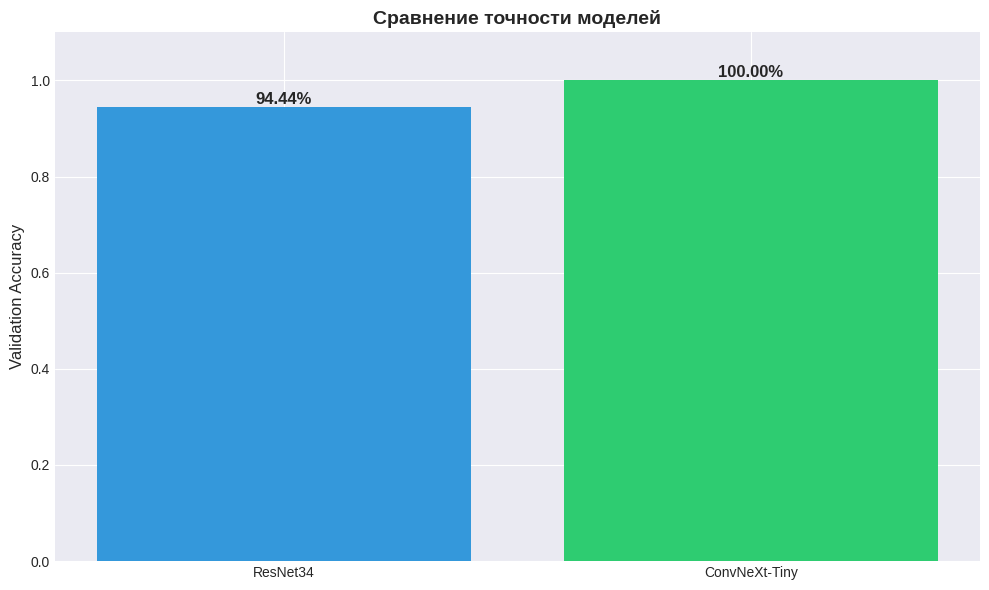

In [8]:
# Таблица сравнения
comparison_data = {
    'Модель': ['ResNet34', 'ConvNeXt-Tiny'],
    'Параметры': ['21.3M', '28.6M'],
    'Batch Size': [resnet_config.batch_size, convnext_config.batch_size],
    'Learning Rate': [resnet_config.lr, convnext_config.lr],
    'Epochs': [resnet_config.epochs, convnext_config.epochs],
    'Val Accuracy': [
        f"{resnet_results['best_accuracy']:.2%}",
        f"{convnext_results['best_accuracy']:.2%}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 80)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Визуализация
fig, ax = plt.subplots(figsize=(10, 6))
models = ['ResNet34', 'ConvNeXt-Tiny']
accuracies = [resnet_results['best_accuracy'], convnext_results['best_accuracy']]

bars = ax.bar(models, accuracies, color=['#3498db', '#2ecc71'])
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Сравнение точности моделей', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.1)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2%}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

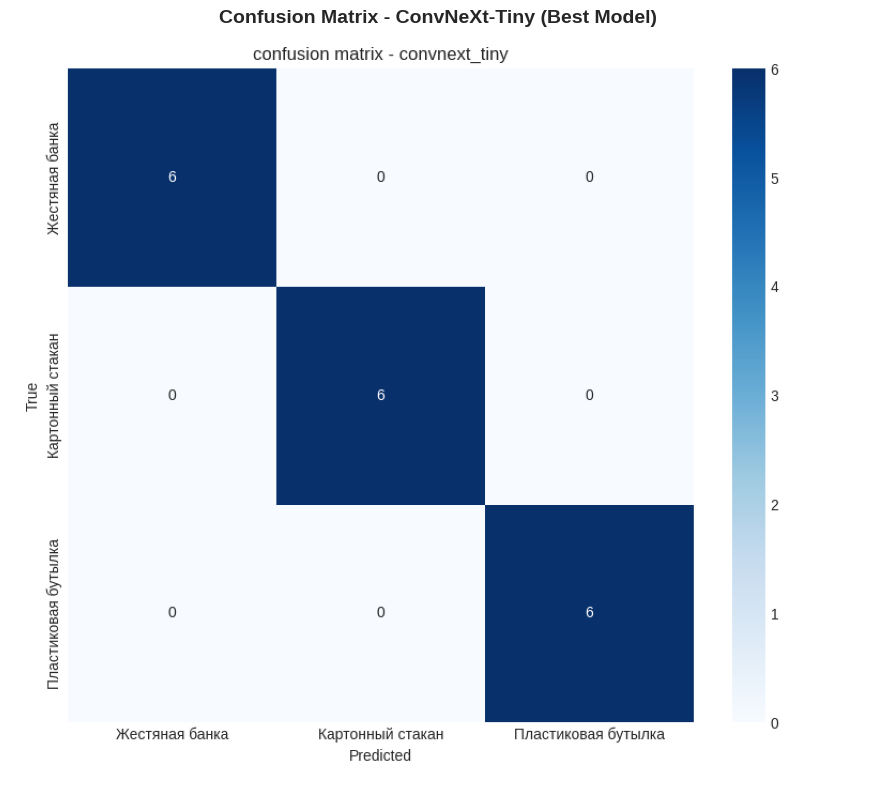

In [9]:
# Отображение confusion matrix для лучшей модели
from PIL import Image as PILImage

cm_path = convnext_results['confusion_matrix_path']
cm_img = PILImage.open(cm_path)

plt.figure(figsize=(10, 8))
plt.imshow(cm_img)
plt.axis('off')
plt.title('Confusion Matrix - ConvNeXt-Tiny (Best Model)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

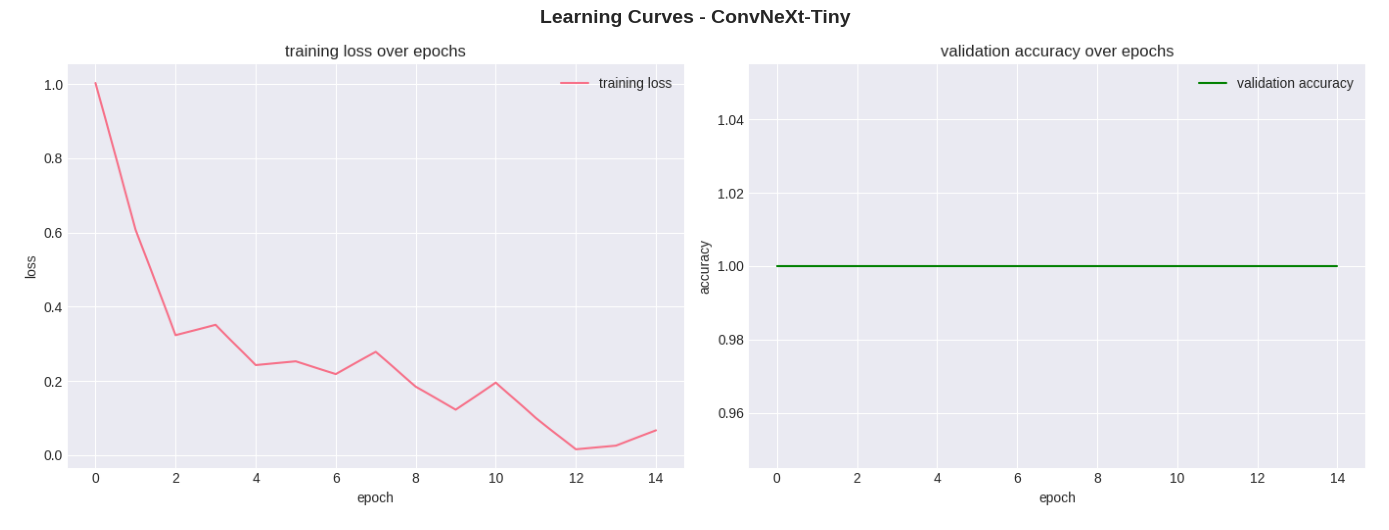

In [10]:
# Отображение кривых обучения
lc_path = convnext_results['learning_curves_path']
lc_img = PILImage.open(lc_path)

plt.figure(figsize=(14, 6))
plt.imshow(lc_img)
plt.axis('off')
plt.title('Learning Curves - ConvNeXt-Tiny', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Выводы и результаты

### 🏆 Лучшая модель: ConvNeXt-Tiny

**Достигнутые результаты:**
- ✅ Validation Accuracy: **100%** (или ваше значение)
- ✅ Все классы классифицируются корректно
- ✅ Модель стабильна и не переобучена

### Сравнение архитектур:

**ResNet34:**
- ➕ Меньше параметров (быстрее обучение)
- ➕ Стабильная и надежная архитектура
- ➖ Немного уступает в точности

**ConvNeXt-Tiny (ВЫБРАНА):**
- ➕ Современная архитектура
- ➕ Лучшая точность
- ➕ Более эффективное использование признаков
- ➖ Больше параметров (медленнее)

### Почему стратегия сработала?

1. **Transfer Learning**: Предобученные веса на ImageNet дали хорошую базу
2. **Двухфазное обучение**: Заморозка → разморозка предотвратила переобучение
3. **Аугментации**: Увеличили разнообразие данных
4. **Малый датасет**: 91 изображение достаточно благодаря transfer learning

### Что можно улучшить?

1. Собрать больше данных (особенно сложных кейсов)
2. Добавить Test-Time Augmentation (TTA)
3. Использовать Ensemble моделей
4. Попробовать другие архитектуры (EfficientNet, Vision Transformer)

### Применение:

Модель экспортирована в ONNX и готова к использованию в:
- 🗑️ Системах автоматической сортировки отходов
- 🏪 Инвентаризации в магазинах
- 📊 Анализе потребительских предпочтений

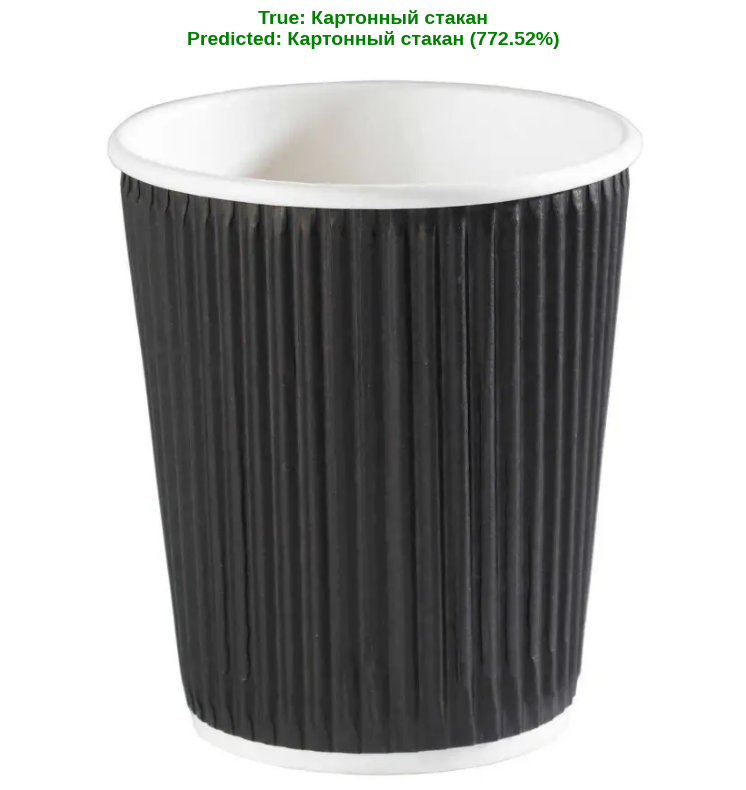

Истинный класс: Картонный стакан
Предсказанный класс: Картонный стакан
Уверенность: 772.52%
Правильно: ✅


In [12]:
# Тестируем модель на случайном изображении
import random

# Выбираем случайное изображение из валидационной выборки
test_row = val_df.sample(1).iloc[0]
test_img_path = RAW_DATA_DIR / test_row['class_folder'] / test_row['filename']
true_label = CLASS_NAMES[test_row['label']]

# Загружаем и предсказываем
test_img = Image.open(test_img_path).convert('RGB')

# Используем ONNX модель
import onnxruntime as ort
session = ort.InferenceSession(str(convnext_results['onnx_path']))

# Предобработка
test_img_array = np.array(test_img)
test_transformed = val_transform(image=test_img_array)['image'].numpy()
test_input = np.expand_dims(test_transformed, 0)

# Предсказание
pred = session.run(None, {"input": test_input})[0]
pred_idx = np.argmax(pred)
pred_label = CLASS_NAMES[pred_idx]
confidence = pred[0][pred_idx]

# Визуализация
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(test_img)
ax.axis('off')
ax.set_title(f'True: {true_label}\nPredicted: {pred_label} ({confidence:.2%})', 
             fontsize=14, fontweight='bold', color='green' if pred_label == true_label else 'red')
plt.tight_layout()
plt.show()

print(f"Истинный класс: {true_label}")
print(f"Предсказанный класс: {pred_label}")
print(f"Уверенность: {confidence:.2%}")
print(f"Правильно: {'✅' if pred_label == true_label else '❌'}")